In [288]:
# import
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
import time


In [289]:
# Helper class

# random seed
# random.seed(30)

class BaseSearch():

    def __init__(self):
        pass
    
    # generate distance matrix from city data
    def distance_matrix(self, csv_data):
        self.num_cities = csv_data.shape[0]
        distance_matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                distance_matrix[i, j] = np.sqrt((csv_data[i, 0] - csv_data[j, 0])**2 + (csv_data[i, 1] - csv_data[j, 1])**2)
        return distance_matrix    
    
    # create a random solution (tour)
    def create_random_solution(self, num_cities):
        solution = list(range(num_cities))
        random.shuffle(solution)
        return solution
    

    # compute total cost of a tour
    def compute_tour_cost(self, tour, distance_matrix):

        # check valid tour
        if not self.is_valid_tour(tour):
            raise ValueError("Invalid tour")

        total_cost = 0
        for i in range(len(tour) - 1):
            total_cost += distance_matrix[tour[i], tour[i + 1]]

        # return to starting city
        total_cost += distance_matrix[tour[-1], tour[0]]
        return total_cost
    

    # check for valid tours - no repeatition of cities
    def is_valid_tour(self, tour):
        return set(tour) == set(range(self.num_cities)) and len(tour) == self.num_cities


    def mutate_solution(self, solution, num_swaps=1):

        # check valid solution
        if not self.is_valid_tour(solution):
            raise ValueError("Invalid tour")
        
        new_solution = solution.copy()

        for _ in range(num_swaps):
            idx1 = random.randint(0, len(new_solution) - 1)
            idx2 = random.randint(0, len(new_solution) - 1)

            # ensure idx1 and idx2 are different
            while idx1 == idx2:
                idx2 = random.randint(0, len(new_solution) - 1)
            new_solution[idx1], new_solution[idx2] = new_solution[idx2], new_solution[idx1]
        return new_solution



    def plot_tour(self, tour, city_data):
        plt.figure("Path")
        plt.title("Tour Path")

        plt.scatter(city_data[:, 0], city_data[:, 1], c='k')
        for i in range(len(tour)):
            city_idx = tour[i]
            plt.text(city_data[city_idx, 0], city_data[city_idx, 1], str(city_idx))

        # check if tour is valid
        if self.is_valid_tour(tour):
            
            #plot the path
            plt.plot(city_data[tour + [tour[0]], 0], city_data[tour + [tour[0]], 1], 'b-')

            #plot start and end points as different colors
            plt.scatter(city_data[tour[0], 0], city_data[tour[0], 1], c='r', label='Start')
            plt.scatter(city_data[tour[-1], 0], city_data[tour[-1], 1], c='g', label='End')

        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')

        plt.legend()
        plt.grid()
        plt.show()



In [290]:
# test cell

# load csv file
ten_citys = np.loadtxt('10-city.csv', delimiter=',', skiprows=1)
twenty_five_citys = np.loadtxt('25-city.csv', delimiter=',', skiprows=1)
hundred_citys = np.loadtxt('100-city.csv', delimiter=',', skiprows=1)

# set city data to use
city_data = hundred_citys

# num_cities = city_data.shape[0]

# # plot cities
# plt.scatter(city_data[:, 0], city_data[:, 1])
# for i in range(num_cities):
#     plt.text(city_data[i, 0], city_data[i, 1], str(i))
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('City Locations')
# plt.grid()
# plt.show()


# base_search = BaseSearch()
# distance_matrix = base_search.distance_matrix(city_data)
# random_solution = base_search.create_random_solution(num_cities)

# base_search.plot_tour(random_solution, city_data)

In [291]:
# simulated annealing search algorithm for TSP

class SimulatedAnnealing(BaseSearch):
    def __init__(self, csv_data, temp = 0.9, temp_decay = 0.9, num_iterations = 1000, num_swaps = 1):
        super().__init__()

        # parameters
        self.csv_data = csv_data
        self.temp = temp
        self.temp_decay = temp_decay
        self.num_iterations = num_iterations
        self.num_swaps = num_swaps

        # distance matrix and initial solution
        self.distance_mat = self.distance_matrix(csv_data)
        self.num_cities = self.distance_mat.shape[0]
        self.tour = self.create_random_solution(self.num_cities)


        # initial tour cost
        self.tour_cost = self.compute_tour_cost(self.tour, self.distance_mat)

        # best tour and cost
        self.best_tour = self.tour
        self.best_tour_cost = self.tour_cost

        # store cost history for plotting
        self.cost_history = [self.tour_cost]

        # store unique solutions explored
        self.solution_space = set()

    
    def probability(self, new_tour_cost):
        return np.exp(-np.divide((new_tour_cost - self.tour_cost), self.temp))
    

    def main_algo(self):

        self.solutions_per_iteration = []

        for i in range(self.num_iterations):

            # generate new solution by mutation
            new_tour = self.mutate_solution(self.tour, self.num_swaps)
            new_tour_cost = self.compute_tour_cost(new_tour, self.distance_mat)

            # decide whether to accept new solution
            if new_tour_cost < self.tour_cost:
                self.tour = new_tour
                self.tour_cost = new_tour_cost

            else:
                acceptance_prob = self.probability(new_tour_cost)
                if random.random() < acceptance_prob:
                    self.tour = new_tour
                    self.tour_cost = new_tour_cost

            # update best tour if needed
            if self.tour_cost < self.best_tour_cost:
                self.best_tour = self.tour
                self.best_tour_cost = self.tour_cost

            # decay temperature
            self.temp *= self.temp_decay

            # store cost history
            self.cost_history.append(self.tour_cost)

            # Update number of swaps every 1/20 of the iterations
            if i % (self.num_iterations // 20) == 0 and i != 0 and self.num_swaps > 1:
                self.num_swaps -= 1
            
            self.solution_space.add(tuple(new_tour))

            self.solutions_per_iteration.append(len(self.solution_space))  
        
        # plot results
        # print("Best tour cost:", self.best_tour_cost)
        # print("Best tour:", self.best_tour)
        # self.plot_tour(self.best_tour, self.csv_data)
    
    def plot_cost_history(self):
        plt.figure("Cost History")
        plt.title("Tour Cost Over Iterations")
        plt.plot(self.cost_history)
        plt.xlabel("Iteration")
        plt.ylabel("Tour Cost")
        plt.legend()
        plt.show()



# test simulated annealing
# parameters
temp = 10
temp_decay = 0.9
num_iterations = 5000
num_swaps = 10

sa_search = SimulatedAnnealing(city_data, temp, temp_decay, num_iterations, num_swaps)
sa_search.main_algo()
# sa_search.plot_cost_history()

# print("Unique solutions explored:", len(sa_search.solution_space))

# print(sa_search.solutions_per_iteration)







number of items in average cost: 15
number of items in std err: 15
number of items in solutions space: 15
Simulated Annealing Results:
Best cost achieved: 1714.8145210421476
Mean best cost: 1919.6182044792479
Standard deviation of best cost: 102.97546139679002
Standard Error of best cost: 26.588149803852833
best tour [47, 89, 87, 56, 41, 61, 78, 99, 76, 14, 42, 21, 38, 88, 73, 29, 31, 90, 95, 80, 63, 96, 91, 26, 74, 24, 11, 65, 0, 18, 4, 46, 2, 66, 7, 23, 6, 83, 39, 20, 1, 54, 82, 10, 19, 35, 49, 17, 28, 5, 53, 62, 9, 81, 72, 70, 37, 60, 8, 71, 13, 3, 86, 77, 43, 40, 68, 97, 16, 15, 79, 69, 64, 44, 33, 85, 59, 92, 84, 36, 55, 48, 25, 51, 57, 34, 45, 30, 50, 22, 67, 27, 12, 94, 32, 58, 98, 75, 52, 93]


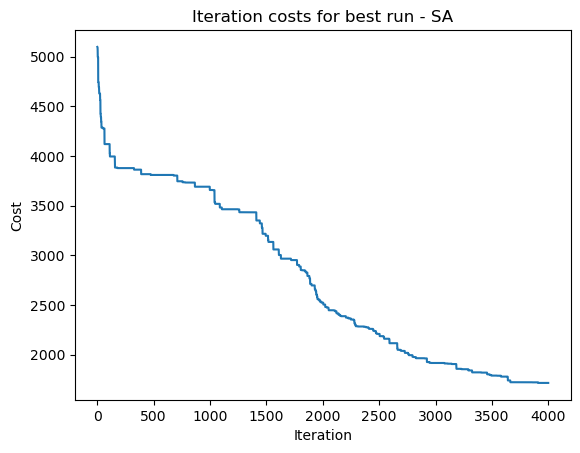

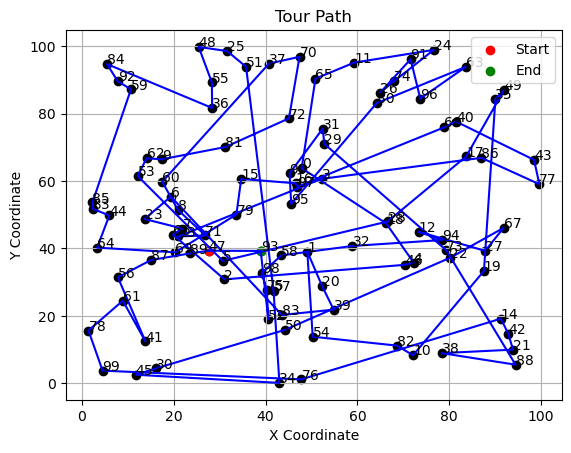

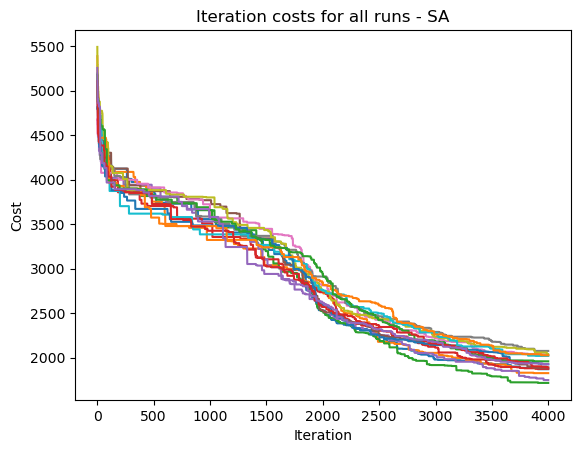

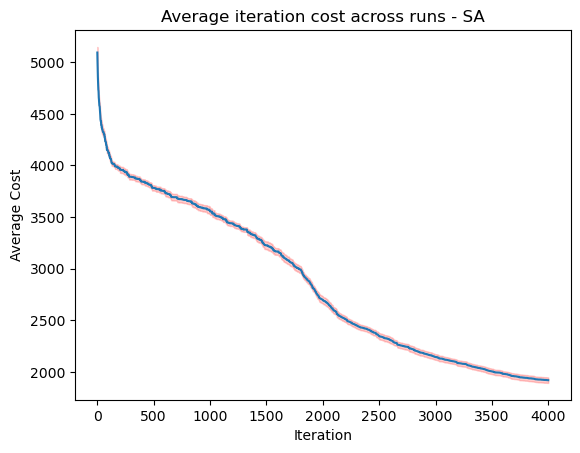

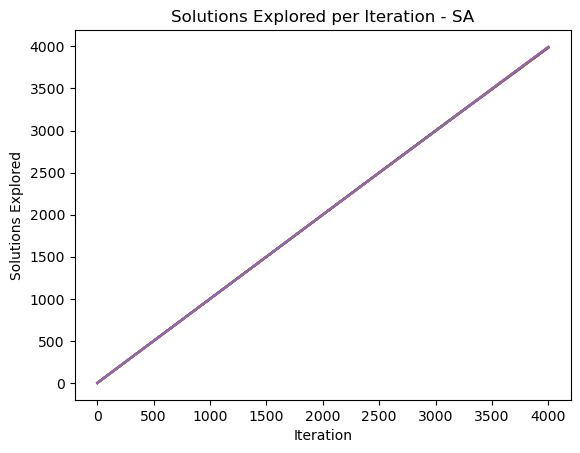

In [292]:
# simulated anealing experiments
temp = 10
temp_decay = 0.9
num_iterations = 4000
num_swaps = 10
runs = 15


#results
best_costs = []
best_tours = []
iteration_costs = []
time_to_run = []

solutions_space = [] 

average_cost = []
std_err = []

for i in range(runs):
    sa_search = SimulatedAnnealing(city_data, temp, temp_decay, num_iterations, num_swaps)
    
    start = time.time()
    sa_search.main_algo()
    end = time.time()

    time_to_run.append(end - start) 
    best_costs.append(sa_search.best_tour_cost)
    best_tours.append(sa_search.best_tour)
    iteration_costs.append(sa_search.cost_history)

    average_cost.append(np.mean(sa_search.cost_history))
    std_err.append(np.std(sa_search.cost_history)/np.sqrt(len(sa_search.cost_history)))

    solutions_space.append(sa_search.solutions_per_iteration)



print(f"number of items in average cost: {len(average_cost)}")
print(f"number of items in std err: {len(std_err)}")
print(f"number of items in solutions space: {len(solutions_space)}")

best_run_idx = np.argmin(best_costs)

# results  
# print("best run cost:", best_costs[best_run_idx])
# print("best run path:", best_tours[best_run_idx])

print("Simulated Annealing Results:")
# print(f"Time taken for each run in sec: {time_to_run}")
print(f"Best cost achieved: {best_costs[best_run_idx]}")
print(f"Mean best cost: {np.mean(best_costs)}")
print(f"Standard deviation of best cost: {np.std(best_costs)}")
print(f"Standard Error of best cost: {np.std(best_costs)/np.sqrt(runs)}")
# print("best costs", best_costs)
print("best tour", best_tours[best_run_idx])


#TODO: 
# get the average of each run and plot that vs iteration
# get the number of solutions searched for each iteration and plot that - should be a line going up


# plots
# Plot iteration costs for best run
plt.figure("Iteration costs for best run - SA")
plt.plot(range(len(iteration_costs[best_run_idx])), iteration_costs[best_run_idx])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration costs for best run - SA")

# Plot best path for best run
sa_search.plot_tour(best_tours[best_run_idx], city_data)

# Plot iteration costs for each run
plt.figure("Iteration costs for each run - SA")
for i in range(runs):
    plt.plot(range(len(iteration_costs[i])), iteration_costs[i])

plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration costs for all runs - SA")


# plot average cost per iteration, with error bars
plt.figure("Average iteration cost across runs - SA")
avg_iteration_cost = np.mean(np.array([itc + [itc[-1]]*(num_iterations - len(itc)) for itc in iteration_costs]), axis=0)
plt.plot(range(len(avg_iteration_cost)), avg_iteration_cost)

# add error bars with matplotlib shading
std_err = np.std(np.array([itc + [itc[-1]]*(num_iterations - len(itc)) for itc in iteration_costs]), axis=0) / np.sqrt(runs)
plt.fill_between(range(len(avg_iteration_cost)), avg_iteration_cost - std_err, avg_iteration_cost + std_err, color='r', alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Average Cost")
plt.title("Average iteration cost across runs - SA")

#plot soultions explored per iteration for all runs
plt.figure("Solutions explored per iteration - SA")
for i in range(runs):
    plt.plot(range(len(solutions_space[i])), solutions_space[i])


plt.xlabel("Iteration")
plt.ylabel("Solutions Explored")
plt.title("Solutions Explored per Iteration - SA")

 

plt.show()





In [293]:
# Evolutionary Algorithm for TSP

# Evolutionary Algorithm for TSP

# add some 

class EvolutionaryAlgorithm(BaseSearch):
    def __init__(self, csv_data, population_size=50, num_generations=1000, mutation_size=10, num_swaps=10):
        super().__init__()

        # parameters
        self.csv_data = csv_data
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_size = mutation_size
        self.num_swaps = num_swaps

        # distance matrix and initial solution
        self.distance_mat = self.distance_matrix(csv_data)
        self.num_cities = self.distance_mat.shape[0]

        # initialize population
        self.population = [self.create_random_solution(self.num_cities) for _ in range(self.population_size)]

        # cost history
        self.population_cost = []
        self.generation_cost = [] # to store the cost of each generation / population cost

        # store number of unique solutions explored
        self.soln_space = set()

        # cost of initial population
        for tour in self.population:
            cost = self.compute_tour_cost(tour, self.distance_mat)
            self.population_cost.append(cost)

        self.generation_cost.append(self.population_cost)   # why not the min ?

        # best tour and cost
        self.best_tour = self.population[np.argmin(self.population_cost)]
        self.best_tour_cost = min(self.population_cost)

        #TODO: top population and costs
        self.best_populations = []
        self.best_populations_cost = []

    # this function is a bit confusing - check it later -------------------------#TODO
    def select_best_populations(self, num_select, population, population_cost):
        # select the top population based on cost

        # selected population and their costs
        selected_population = []
        selected_population_cost = []
        chosen_indices = []

        sorted_indices = np.argsort(population_cost)

        for i in range(num_select):
            idx = sorted_indices[i]
            selected_population.append(population[idx])
            selected_population_cost.append(population_cost[idx])
            chosen_indices.append(idx)

        return (selected_population, selected_population_cost, chosen_indices)
    
    def main_algo(self, show_progress=False):

        self.solns_per_iteration = []

        for i in range(self.num_generations):
            # select best population for mutation
            self.best_populations, self.best_populations_cost, chosen_indices = self.select_best_populations(self.mutation_size, self.population, self.population_cost)

            # mutate best populations to create new population
            new_population = []
            new_population_cost = []

            for tour in self.best_populations:
                mutated_tour = self.mutate_solution(tour, self.num_swaps)
                new_population.append(mutated_tour)
                cost = self.compute_tour_cost(mutated_tour, self.distance_mat)
                new_population_cost.append(cost)

            # get new population by combining population and mutated population
            self.population_buffer = self.population + new_population
            self.population_cost_buffer = self.population_cost + new_population_cost

            # select the next generation population
            self.population, self.population_cost, _ = self.select_best_populations(self.population_size, self.population_buffer, self.population_cost_buffer)

            # store generation cost history
            self.generation_cost.append(self.population_cost)

            # update best tour if needed
            if np.min(self.population_cost) < self.best_tour_cost:
                self.best_tour = self.population[np.argmin(self.population_cost)]
                self.best_tour_cost = np.min(self.population_cost)

            # reduce swap size over generations
            if i % (self.num_generations // 20) == 0 and i != 0 and self.num_swaps > 1:
                self.num_swaps -= 1
            
            # store number of unique solutions explored
            self.soln_space.update(tuple(tour) for tour in self.population)
            self.solns_per_iteration.append(len(self.soln_space))

            
        if show_progress:
            print("Best tour cost:", self.best_tour_cost)
            print("Best tour:", self.best_tour)
            self.plot_tour(self.best_tour, self.csv_data)

        
    def plot_cost_history(self):
        plt.figure("Evolutionary Algorithm Cost History")
        
        plt.title("Tour Cost Over Generations - EA")
        # get min cost for each generation
        min_costs = [min(costs) for costs in self.generation_cost]
        plt.plot(min_costs)
        plt.xlabel("Generation")
        plt.ylabel("Tour Cost")
        plt.legend()
        plt.show()

            
    

Evolutionary Algorithm Results:
Best cost achieved: 1300.7902579867728
Mean best cost: 1411.5344189210628
Standard deviation of best cost: 64.30662772446932
Standard Error of best cost: 16.60389988184199
best tour [54, 5, 89, 66, 13, 7, 8, 6, 60, 62, 36, 55, 25, 51, 81, 15, 90, 0, 18, 28, 22, 19, 27, 86, 67, 94, 73, 12, 32, 3, 97, 16, 9, 53, 23, 44, 64, 41, 45, 30, 50, 83, 57, 52, 75, 98, 2, 93, 95, 35, 49, 63, 24, 91, 74, 80, 11, 26, 31, 29, 72, 65, 70, 37, 48, 84, 59, 92, 33, 85, 79, 1, 20, 39, 4, 17, 68, 96, 40, 43, 77, 14, 21, 88, 42, 46, 58, 47, 71, 69, 87, 56, 61, 78, 99, 34, 76, 10, 38, 82]


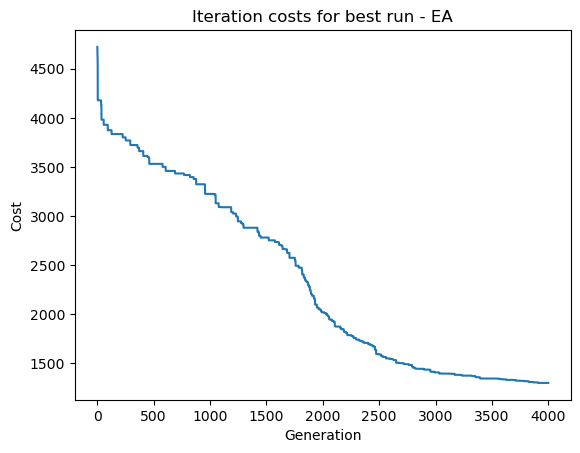

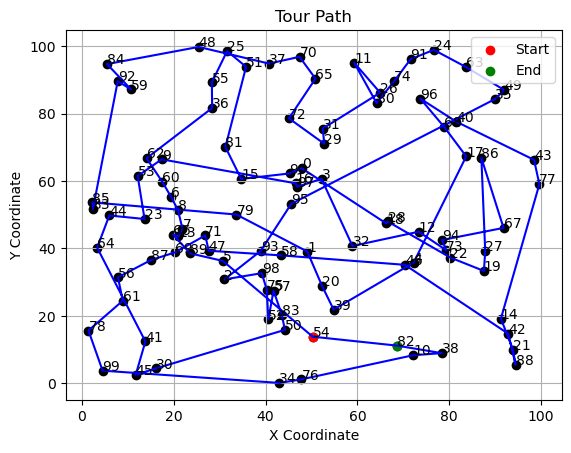

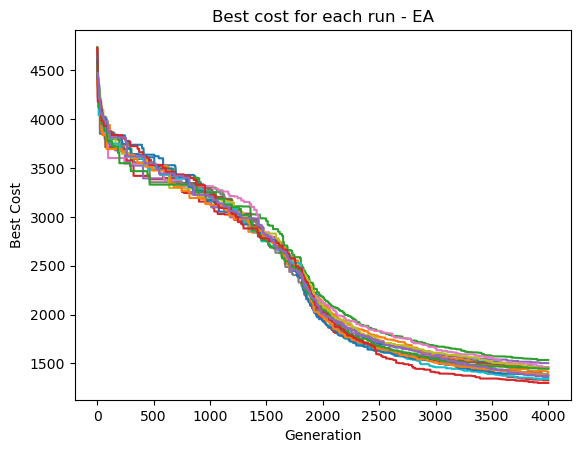

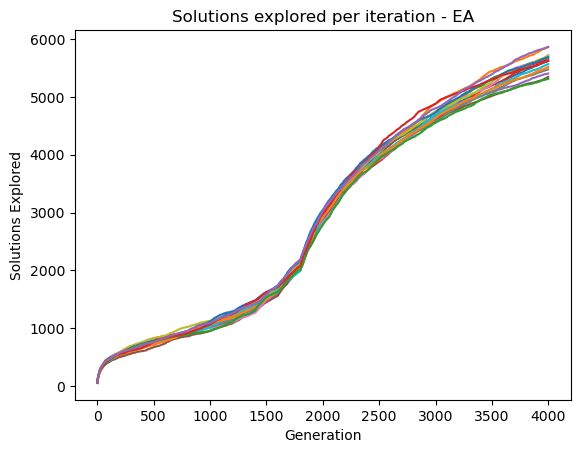

Text(0.5, 1.0, 'Average iteration cost across runs - EA')

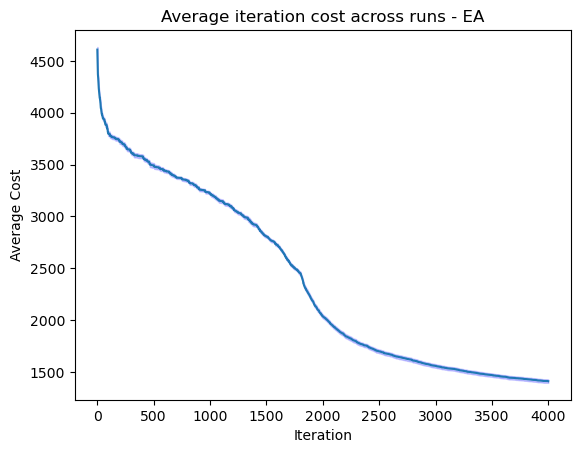

In [ ]:
# experiments for Evolutionary Algorithm
# parameters
population_size = 50
num_generations = 4000
mutation_size = 25
num_swaps = 10
runs = 15

#results
best_costs = []
best_tours = []
time_to_run = []
iteration_costs = []

# solutions per iteration
solutions_space = []

average_cost = []
std_err = []

for i in range(runs):
    ea_search = EvolutionaryAlgorithm(city_data, population_size, num_generations, mutation_size, num_swaps)
    
    start = time.time()
    ea_search.main_algo()
    end = time.time()

    time_to_run.append(end - start) 
    best_costs.append(ea_search.best_tour_cost)
    best_tours.append(ea_search.best_tour)
    iteration_costs.append([min(costs) for costs in ea_search.generation_cost])
    solutions_space.append(ea_search.solns_per_iteration)

    #average and std err
    average_cost.append(np.mean([min(costs) for costs in ea_search.generation_cost]))
    std_err.append(np.std([min(costs) for costs in ea_search.generation_cost])/np.sqrt(len(ea_search.generation_cost)))



best_run_idx = np.argmin(best_costs)




# Find best run
best_run_idx = np.argmin(best_costs)


# results
# print("best run cost:", best_costs[best_run_idx])
# print("best run path:", best_tours[best_run_idx])
print("Evolutionary Algorithm Results:")
# print(f"Time taken for each run in sec: {time_to_run}")
print(f"Best cost achieved: {best_costs[best_run_idx]}")
print(f"Mean best cost: {np.mean(best_costs)}")
print(f"Standard deviation of best cost: {np.std(best_costs)}")
print(f"Standard Error of best cost: {np.std(best_costs)/np.sqrt(runs)}")
# print("best costs", best_costs)
print("best tour", best_tours[best_run_idx])




# plots
# Plot iteration costs for best run
plt.figure("Iteration costs for best run - EA")
plt.plot(range(len(iteration_costs[best_run_idx])), iteration_costs[best_run_idx])
plt.xlabel("Generation")
plt.ylabel("Cost")
plt.title("Iteration costs for best run - EA")

# Plot best path for best run
ea_search.plot_tour(best_tours[best_run_idx], city_data)


# Plot generation best costs for each run
plt.figure("Generation costs for each run - EA")
for i in range(runs):
    plt.plot(range(len(iteration_costs[i])), iteration_costs[i])
plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("Best cost for each run - EA")


# plot soultions explored per iteration
plt.figure("Solutions explored per iteration - EA")
for i in range(runs):
    plt.plot(range(len(solutions_space[i])), solutions_space[i])
plt.xlabel("Generation")
plt.ylabel("Solutions Explored")
plt.title("Solutions explored per iteration - EA")
plt.show()


# plot average cost across runs per iteration, with error bars

# plot average cost per iteration, with error bars
plt.figure("Average iteration cost across runs")
avg_iteration_cost = np.mean(np.array([itc + [itc[-1]]*(num_generations - len(itc)) for itc in iteration_costs]), axis=0)
plt.plot(range(len(avg_iteration_cost)), avg_iteration_cost)

# add error bars with matplotlib shading
std_err = np.std(np.array([itc + [itc[-1]]*(num_generations - len(itc)) for itc in iteration_costs]), axis=0) / np.sqrt(runs)
plt.fill_between(range(len(avg_iteration_cost)), avg_iteration_cost - std_err, avg_iteration_cost + std_err, color='b', alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Average Cost")
plt.title("Average iteration cost across runs - EA")




